# Benchmark Model

**Purpose of script:**

Define a benchmark model for performance comparisons

### Data Prep

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

In [4]:
df_path = r"../Data/combined/"

In [6]:
df = pd.read_parquet(df_path + 'melt_2019-07-01_extended.parquet.gzip')
# fillna

In [8]:
X = df[['x', 'y', 'mw_value', 'col', 'row', 'v1', 'v2', 'v3', 'v4', 'v6', 'v7', 'v8', 'v9',  'mean']] # 'date',# v5 is duplicated
y = df[['opt_value']]

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training, 20% test and 10% validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=1)

In [ ]:
#def data_prep(data_path):

## Baseline models

### Baseline Regression

In [24]:
y_predicted = np.full((1, len(y_test)), y_train.mean())[0]

In [25]:
rmse2 = np.sqrt(mean_squared_error(y_test, y_predicted))

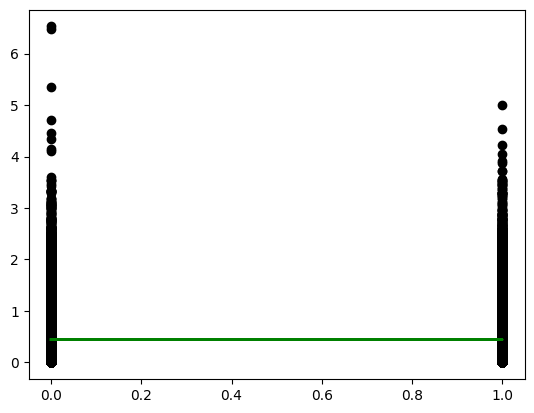

In [30]:
plt.scatter(X_test['mw_value'], y_test,  color='black')
plt.plot(X_test['mw_value'], y_predicted, color='green', linewidth=2)

### Baseline Classification

In [ ]:
# threshold was 0.64?

In [ ]:
# baseline classifier - predict all 0 - majority class?
# and baseline when majority class in buckets